In [35]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import meshplot
# for display of meshes
#https://skoch9.github.io/meshplot/tutorial/

from pyquaternion import Quaternion
#http://kieranwynn.github.io/pyquaternion/

In [189]:
# making a class for the dice d8 
class dice_d8():
    # make a d8 with length 1 between top and bottom verticles 
    # and length 1 between opposite equatorial vertices
    def __init__(self):
        self.nv = 6  # number of vertices
        self.nf = 8  # number of faces
        self.vertices = np.zeros((self.nv,3))  # list of 6 points, each with three coordinates
        self.faces = np.zeros((self.nf,3),dtype=int)  # 8 faces each listing 3 vertices
        hfac = 2  # gives length 1 between opposite vertices  on equator
        vfac = 2  # gives length 1 between opposite vertices on poles
        self.vertices[0,:] = np.array([ 0, 0, 1])/vfac  # top
        self.vertices[1,:] = np.array([ 1, 0, 0])/hfac  # equatorial
        self.vertices[2,:] = np.array([ 0, 1, 0])/hfac  # equatorial
        self.vertices[3,:] = np.array([-1, 0, 0])/hfac  # equatorial
        self.vertices[4,:] = np.array([ 0,-1, 0])/hfac  # equatorial
        self.vertices[5,:] = np.array([ 0, 0,-1])/vfac  # bottom
        
        self.faces[0,:] = np.array([0,1,2])
        self.faces[1,:] = np.array([0,2,3])
        self.faces[2,:] = np.array([0,3,4])
        self.faces[3,:] = np.array([0,4,1])
        self.faces[4,:] = np.array([5,2,1])
        self.faces[5,:] = np.array([5,3,2])
        self.faces[6,:] = np.array([5,4,3])
        self.faces[7,:] = np.array([5,1,4])
        # these have been checked for outward orientation (but not 100% sure yet)
        
        # compute face normal unit vectors
        self.face_normals =  np.zeros((self.nf,3)) 
        self.compute_face_normals()
        
        # compute face centroid positions
        self.face_centroids = np.zeros((self.nf,3)) 
        self.compute_face_centroids()
        
        # find out whether the vertices are visible, viewer assumed to be on the +z axis direction
        self.v_visible  = np.zeros(self.nv,dtype=int) 
        self.compute_isvisible()
    
    # loop over faces to compute face normal vectors
    def compute_face_normals(self):
        for iface in range(self.nf):
            iv0 = self.faces[iface,0]  # this is an index for a vertex
            iv1 = self.faces[iface,1]
            iv2 = self.faces[iface,2]
            v0 = self.vertices[iv0,:]  # these are the three vertices
            v1 = self.vertices[iv1,:]
            v2 = self.vertices[iv2,:]
            dv01 = v1-v0  # edge directions 
            dv12 = v2-v1 
            nvec = cross_prod_2vecs(dv01,dv12)  # compute cross product
            nvec/= len_vec(nvec)  # normalize 
            self.face_normals[iface,:] = nvec
     
    # compute the centroid of each face
    def compute_face_centroids(self):
        for iface in range(self.nf):
            iv0 = self.faces[iface,0]  # this is an index for a vertex
            iv1 = self.faces[iface,1]
            iv2 = self.faces[iface,2]
            v0 = self.vertices[iv0,:]  # these are the three vertices
            v1 = self.vertices[iv1,:]
            v2 = self.vertices[iv2,:]
            vc = (v0+v1+v2)/3.0  # centroid
            self.face_centroids[iface,:] = vc
        
    # compute and return center of mass coordinate position
    def com(self):
        nv = len(self.vertices)
        xcom = np.sum(self.vertices[:,0])/nv
        ycom = np.sum(self.vertices[:,1])/nv
        zcom = np.sum(self.vertices[:,2])/nv
        return np.array([xcom,ycom,zcom])
    
    # rotate the dice by angle phi in radians about r_axis using a quaturnion
    # rotate about the center of mass 
    def rotate(self,r_axis,phi):
        q = Quaternion(axis=r_axis, angle=phi)
        nv = len(self.vertices)
        com_position  = self.com() #compute center of mass 
        for i in range(nv):
            v = np.squeeze(self.vertices[i,:]) - com_position  # a vertex w.r.t to center of mass
            v = q.rotate(v)  # rotate it with the quaturnion
            v += com_position # restore center of mass position
            self.vertices[i,:] = v   # replace with rotated vertex
        self.compute_face_normals()  # update face normal vectors
        self.compute_face_centroids() # update face centroids
        self.compute_isvisible()  # update visibility of vertices
        
    # are vertices visible from +z direction of viewing?
    # this routine seems to work now
    # vertex is assumed visible if one face that it is connect to 
    # is lit with illumination coming from +z
    # we find out if a face is lit if the face normal has a +z component
    def compute_isvisible(self):
        self.v_visible *=0  # reset to zero
        for iface in range(self.nf):
            if (self.face_normals[iface,2] >= 0):  # sun lit
                iv0 = self.faces[iface,0]  # this is an index for a vertex
                iv1 = self.faces[iface,1]
                iv2 = self.faces[iface,2]
                self.v_visible[iv0]=1
                self.v_visible[iv1]=1
                self.v_visible[iv2]=1
                                         

# compute cross product of C=A X B for 3D vectors A,B, return C
def cross_prod_2vecs(A,B):
    C0 = A[1]*B[2] - A[2]*B[1]
    C1 = A[2]*B[0] - A[0]*B[2]
    C2 = A[0]*B[1] - A[1]*B[0]
    return np.array([C0,C1,C2])

# return the length of a vector
def len_vec(A):
    r2=0.0
    for i in range(3):
        r2 += A[i]**2
    return np.sqrt(r2)


# plot the edges of all the faces as a blue wireframe    
# arguments:
#   ax is axis for plotting
#   dice  (class dice_d8)
def plt_edges(ax,dice):
    nf = len(dice.faces)
    f = dice.faces
    v = dice.vertices
    cc = 'skyblue'
    for i in range(nf):
        iv0 = f[i,0]  # this is an index!
        iv1 = f[i,1]
        iv2 = f[i,2]
        v0x = v[iv0,0]; v0y = v[iv0,1]
        v1x = v[iv1,0]; v1y = v[iv1,1]
        v2x = v[iv2,0]; v2y = v[iv2,1]
        
        ax.plot([v0x,v1x],[v0y,v1y],'-',color=cc)
        ax.plot([v1x,v2x],[v1y,v2y],'-',color=cc)
        ax.plot([v0x,v2x],[v0y,v2y],'-',color=cc)
        
# plot the face normal vectors as arrows
# this is to check the directions and face orientations
# arrows are orange if z component is positive, brown otherwise
def plt_face_normals(ax,dice):  
    nf = len(dice.faces)
    n = dice.face_normals
    fc = dice.face_centroids
    xvals = np.squeeze(fc[:,0])
    yvals = np.squeeze(fc[:,1])
    dxvals = np.squeeze(n[:,0])
    dyvals = np.squeeze(n[:,1])
    dzvals = np.squeeze(n[:,2])
    ii = dzvals >= 0
    ax.quiver(xvals[ii],yvals[ii],dxvals[ii],dyvals[ii],color='orange')
    ii = dzvals < 0
    ax.quiver(xvals[ii],yvals[ii],dxvals[ii],dyvals[ii],color='brown')
    
# plot visible vertices  
# plot poles as red, equatorial points in green
def plt_visible_vertices(ax,dice):
    v = dice.vertices
    xvals = np.squeeze(v[:,0])
    yvals = np.squeeze(v[:,1])
    ii = (dice.v_visible >0)  # visible vertices
    red_vertices = np.array([True, False, False, False, False, True])
    green_vertices = np.logical_not(red_vertices)
    ii_red = (ii & red_vertices)
    ii_green = (ii & green_vertices)
    ax.plot(xvals[ii_green],yvals[ii_green],'go')  # plot equatorial points in green
    ax.plot(xvals[ii_red],yvals[ii_red],'ro')  # plot poles as red


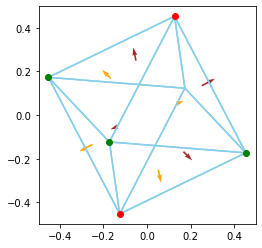

In [190]:
# tests!
dice = dice_d8()
theta = -3*np.pi/2;  lat = np.pi/5
r_axis = np.array([np.cos(theta)*np.sin(lat),np.sin(theta)*np.sin(lat),np.cos(lat)])
phi = 2.7
dice.rotate(r_axis,phi)  # rotate the dice and display
#meshplot.plot(dice.vertices, dice.faces) 
fig,ax = plt.subplots(1,1,figsize=(4,4))
ax.set_aspect('equal')
plt_edges(ax,dice)  # display edges as a blue wireframe
plt_face_normals(ax,dice)  # display face normals at face centroids
plt_visible_vertices(ax,dice)  # only plot visible vertices
# looks ok 

In [191]:
#theta = np.pi/4;  lat = np.pi/8
#r_axis = np.array([np.cos(theta)*np.sin(lat),np.sin(theta)*np.sin(lat),np.cos(lat)])
#phi = np.pi/8
#dice.rotate(r_axis,phi)  # rotate the dice and display
meshplot.plot(dice.vertices, dice.faces) 

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [ ]:
# looks like quaturnion rotate works

In [218]:
# move and rotate the d8 dice, return tracks
# arguments:
#   vx:  center of mass velocity in x direction
#   dt:  timestep
#   ndt: number of timesteps to do (integer)
#   r_axis: rotation axis is a length 3 array
#   phi_dot: spin rate
# returns tracks and their visibility
#    xarr,yarr 2d arrays of x,y,z coordinates of vertices at different times
def model_tracks_dice(vx,r_axis,phidot,dt,ndt):
    dice = dice_d8()  # start with dice at generic orientation
    dphi = phidot*dt
    xarr = np.zeros((6,ndt))  # xpositions of 6 verticles at ndt timesteps
    yarr = np.zeros((6,ndt))
    zarr = np.zeros((6,ndt))
    v_visible = np.zeros((6,ndt),dtype = int)  # is the vertex visible
    for i in range(ndt): # loop over timesteps
        dice.rotate(r_axis,dphi)  # rotate by dphi
        xpos = np.squeeze(dice.vertices[:,0]) + vx*dt*i  # xcoords of each vertex
        ypos = np.squeeze(dice.vertices[:,1])   # ycoords of each vertex
        zpos = np.squeeze(dice.vertices[:,2])   # zcoords of each vertex
        xarr[:,i] = xpos
        yarr[:,i] = ypos
        zarr[:,i] = zpos
        v_visible[:,i] = dice.v_visible
    tarr = np.arange(ndt)*dt  # times
    return tarr,xarr,yarr,zarr,v_visible

# same as above except plot edges every di index in the series
# and plot visible vertices at the same time
def move_and_rotate_i(ax,di,vx,r_axis,phidot,dt,ndt,plot_e, plot_v):
    dice = dice_d8()  # start with dice at generic orientation
    dphi = phidot*dt*di
    if (plot_e >0):
        plt_edges(ax,dice)  # plot all edges wireframe
    if (plot_v >0):
        plt_visible_vertices(ax,dice)  # plot visible vertices in red and green

    for i in range(int(ndt/di)):
        dice.rotate(r_axis,dphi)  # rotate by dphi
        dice.vertices[:,0] += vx*dt*di
        if (plot_e >0):
            plt_edges(ax,dice)  # plot all edges wireframe
        if (plot_v >0):
            plt_visible_vertices(ax,dice)  # plot visible vertices in red and green


<Figure size 432x288 with 0 Axes>

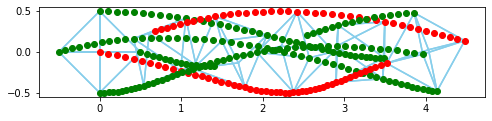

In [208]:
vx = 0.2;   # center of mass velocity
theta = 0.3*np.pi;  lat = 0.7*np.pi
r_axis = np.array([np.cos(theta)*np.sin(lat),np.sin(theta)*np.sin(lat),np.cos(lat)]) # rotation axis
dt = 0.4 # timestep
ndt = 50 # number of timesteps
phidot = 0.2 # angular velocity in radians/time
#xarr,yarr,zarr,v_visible = move_and_rotate_dice(vx,r_axis,phidot,dt,ndt)

plt.figure()
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.set_aspect('equal')

# do stuff every  di frames
di=10;  move_and_rotate_i(ax,di,vx,r_axis,phidot,dt,ndt,1,0)  # plot plot wireframe
di=1;  move_and_rotate_i(ax,di,vx,r_axis,phidot,dt,ndt,0,1)   # plot visible vertices

In [231]:
# tarr,xarr,yarr,zarr,v_visible are vertex tracks produced via
#  model_tracks_dice, plot tracks (visible vertices only) in a figure as a function of x,y
def plt_tracks_xy(tarr,xarr,yarr,zarr,v_visible):
    plt.figure()
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    iv = 0 # red vertex 
    vvis = np.squeeze(v_visible[iv,:]) > 0  # is visible
    ax.plot(np.squeeze(xarr[iv,vvis]),np.squeeze(yarr[iv,vvis]), 'r.')
    iv = 5 # another red vertex
    vvis = np.squeeze(v_visible[iv,:]) > 0
    ax.plot(np.squeeze(xarr[iv,vvis]),np.squeeze(yarr[iv,vvis]), 'r.')

    # green vertices
    for iv in range(1,5):
        vvis = np.squeeze(v_visible[iv,:]) > 0
        ax.plot(np.squeeze(xarr[iv,vvis]),np.squeeze(yarr[iv,vvis]), 'g.')
        
# plot x positions as a function of time for all tracks        
def plt_tracks_xt(tarr,xarr,yarr,zarr,v_visible):
    plt.figure()
    fig,ax = plt.subplots(1,1,figsize=(5,4))
    #ax.set_aspect('equal')
    ax.set_xlabel('t')
    ax.set_ylabel('x')

    iv = 0 # red vertex 
    vvis = np.squeeze(v_visible[iv,:]) > 0  # is visible
    ax.plot(tarr[vvis],np.squeeze(xarr[iv,vvis]), 'r.')
    iv = 5 # another red vertex
    vvis = np.squeeze(v_visible[iv,:]) > 0
    ax.plot(tarr[vvis],np.squeeze(xarr[iv,vvis]), 'r.')
    
    # green vertices
    for iv in range(1,5):
        vvis = np.squeeze(v_visible[iv,:]) > 0
        ax.plot(tarr[vvis],np.squeeze(xarr[iv,vvis]), 'g.')
        
        
# plot y positions as a function of time for all tracks        
def plt_tracks_yt(tarr,xarr,yarr,zarr,v_visible):
    plt.figure()
    fig,ax = plt.subplots(1,1,figsize=(5,4))
    #ax.set_aspect('equal')
    ax.set_xlabel('t')
    ax.set_ylabel('y')

    iv = 0 # red vertex 
    vvis = np.squeeze(v_visible[iv,:]) > 0  # is visible
    ax.plot(tarr[vvis],np.squeeze(yarr[iv,vvis]), 'r.')
    iv = 5 # another red vertex
    vvis = np.squeeze(v_visible[iv,:]) > 0
    ax.plot(tarr[vvis],np.squeeze(yarr[iv,vvis]), 'r.')
    
    # green vertices
    for iv in range(1,5):
        vvis = np.squeeze(v_visible[iv,:]) > 0
        ax.plot(tarr[vvis],np.squeeze(yarr[iv,vvis]), 'g.')

<Figure size 432x288 with 0 Axes>

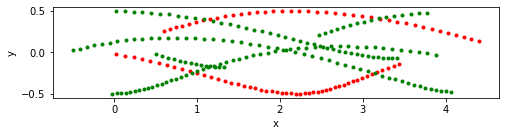

<Figure size 432x288 with 0 Axes>

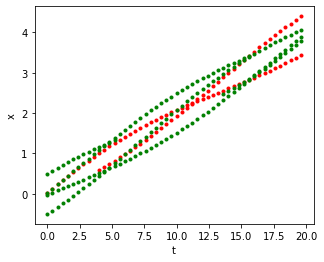

In [230]:
# get tracks!
tarr,xarr,yarr,zarr,v_visible = model_tracks_dice(vx,r_axis,phidot,dt,ndt)
# plot tracks x,y
plt_tracks_xy(tarr,xarr,yarr,zarr,v_visible)

# plt tracks x vs t
plt_tracks_xt(tarr,xarr,yarr,zarr,v_visible)
# plt tracks y vs t
plt_tracks_xt(tarr,xarr,yarr,zarr,v_visible)